## Import libraries

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
from matplotlib.pyplot import rc_context
import os

In [2]:
# Set multithreading
sc._settings.ScanpyConfig.n_jobs=-1
sc._settings.ScanpyConfig.max_memory=128

## Read data

In [3]:
ROOT_DIR = os.path.join("/", "home", "nikiarte", "scrnaseq")
raw_counts_path = os.path.join(ROOT_DIR, "raw_counts", "GSE130879_RAW")
h5_samples_file_path = os.path.join(raw_counts_path, "samples.txt")


In [4]:
h5_samples_file_path


'/home/nikiarte/scrnaseq/raw_counts/GSE130879_RAW/samples.txt'

In [5]:
adata_dict = {}
with open(h5_samples_file_path, 'r', encoding='utf-8') as h5_samples_file:
    for line in h5_samples_file:
        sample_id = line.split("_")[2]
        h5_sample_path = os.path.join(raw_counts_path, line[0:-1])
        sample_adata = sc.read_10x_h5(h5_sample_path)
        sample_adata.var_names_make_unique()
        adata_dict[sample_id] = sample_adata
        
adata = ad.concat(adata_dict, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata    


        

/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.v

sample
Spleen    737280
Fat       737280
Skin      737280
Blood     737280
LN        737280
BM        737280
Lung      737280
Liver     737280
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 5898240 × 27998
    obs: 'sample'

In [6]:
adata.X.shape

(5898240, 27998)

## Preprocessing

In [7]:
# Mark mitochondrial genes
adata.var['mt'] = adata.var.index.str.startswith('mt-')
# Mark ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa"))
# Mark hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p, e, s)]")

In [8]:
# Filter genes with lower than 3 reads
sc.pp.filter_genes(adata, min_cells=3)
# Remove cells with few reads
sc.pp.filter_cells(adata, min_genes=200)
#adata.obs.sort_values('total_counts')

In [54]:
# Calculate percentage of cells with mitochondrial reads
sc.pp.calculate_qc_metrics(adata,
                           qc_vars=['mt'],
                           percent_top=None,
                           log1p=True,
                           inplace=True)

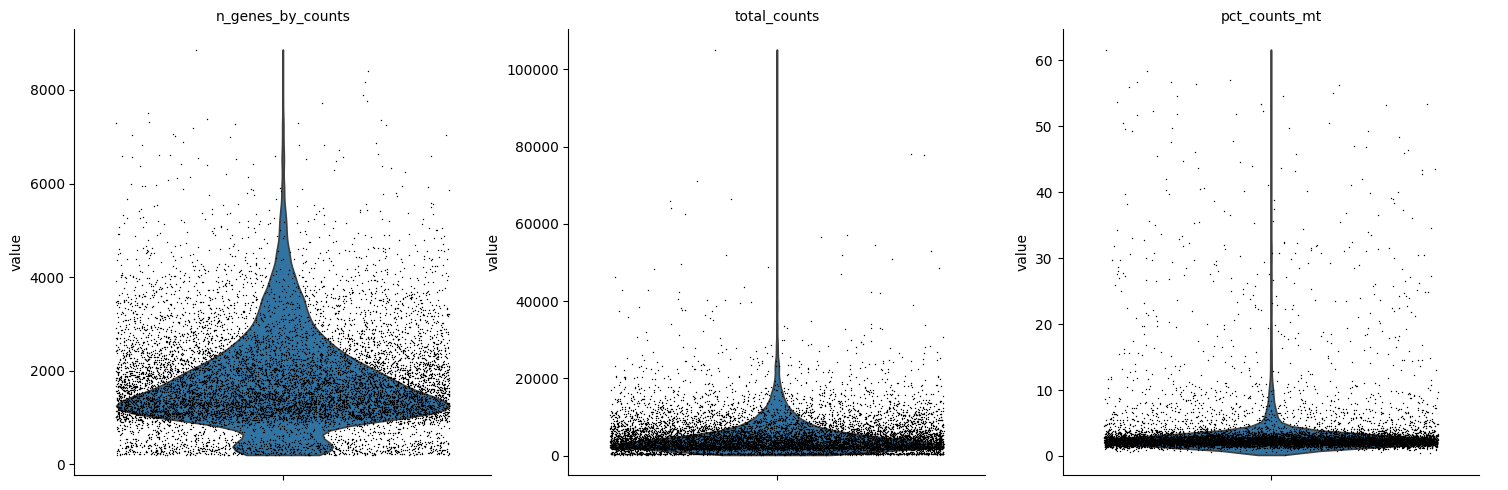

In [55]:
# Plot QCs
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## Doublet removal

In [56]:
sc.pp.scrublet(adata, batch_key="sample")

## Plot counts and mitochondrial counts

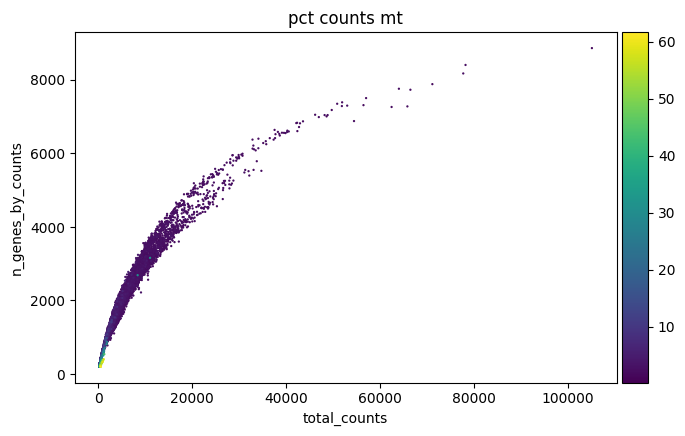

In [57]:
sc.pl.scatter(
    adata,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt")

In [58]:
adata.shape

(11059, 16521)

## Normalization

In [59]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [60]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

In [61]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

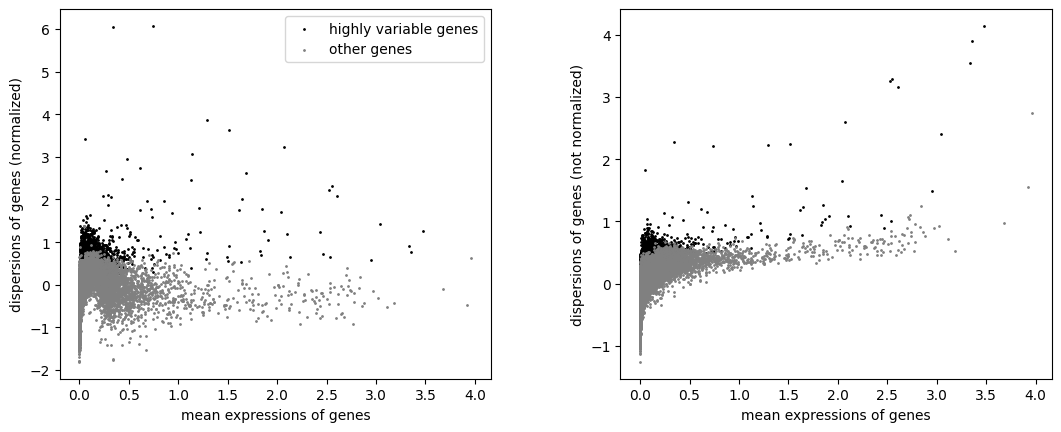

In [62]:
sc.pl.highly_variable_genes(adata)

## Dimensionality reduction

In [63]:
sc.tl.pca(adata)

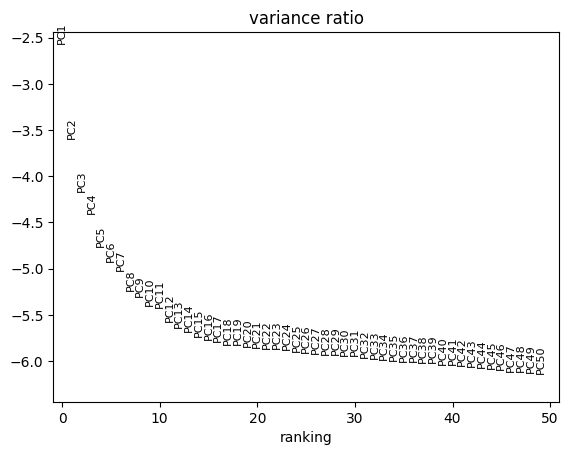

In [64]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

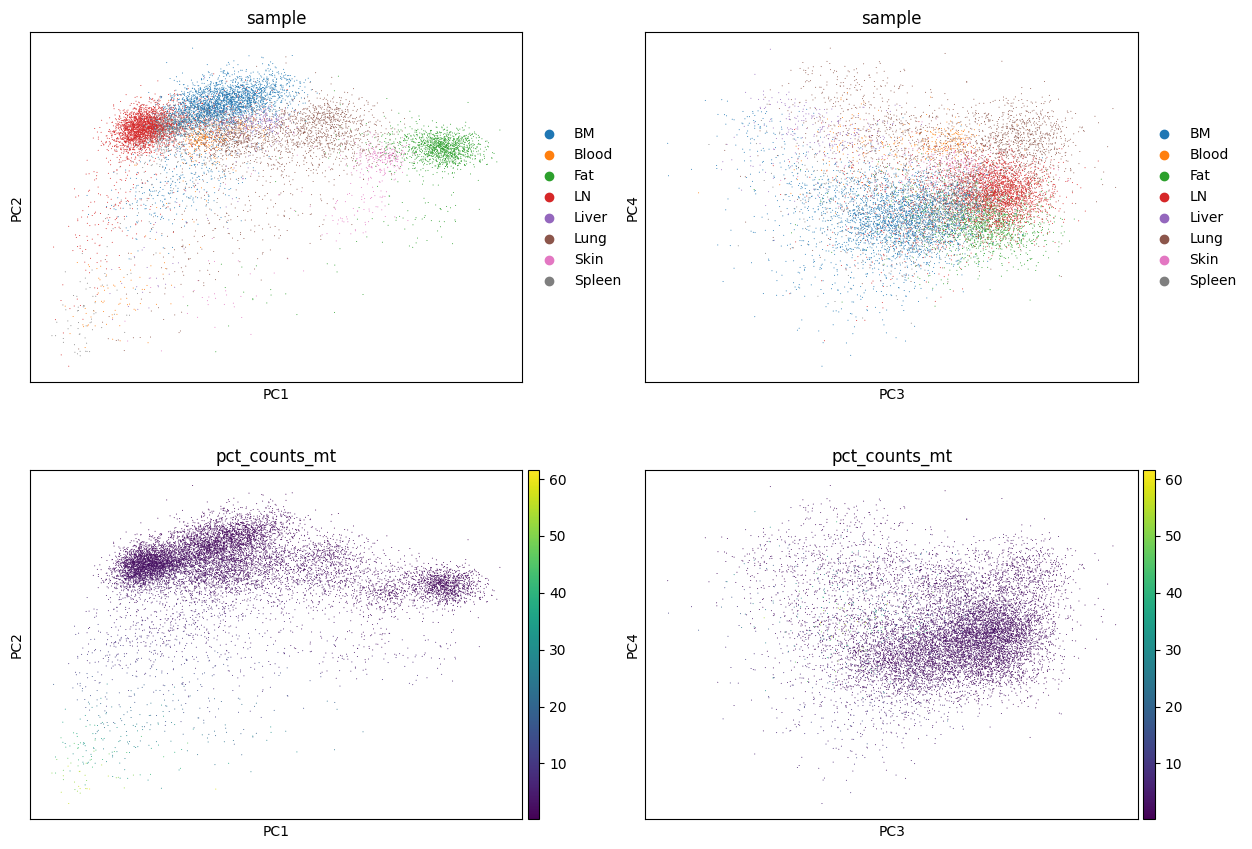

In [65]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest neighbor graph

In [66]:
sc.pp.neighbors(adata)

In [67]:
sc.tl.umap(adata)

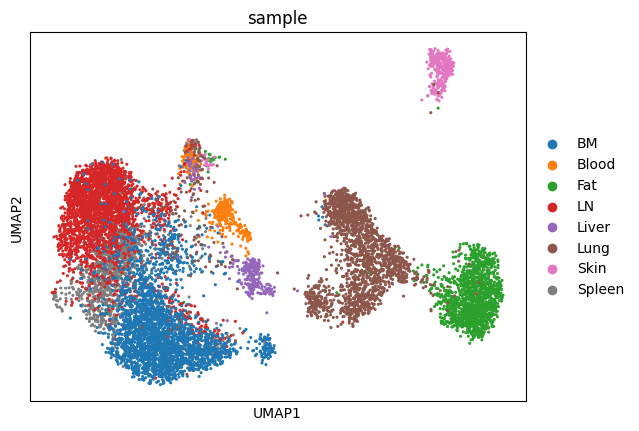

In [68]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=20,
)

## Clustering

In [69]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

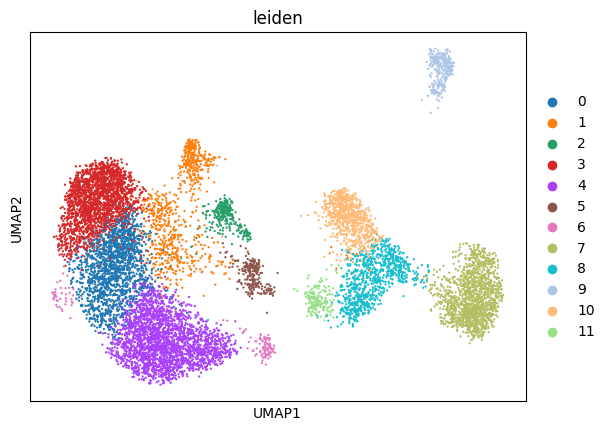

In [70]:
sc.pl.umap(adata, color=["leiden"])

## Reassessing QC

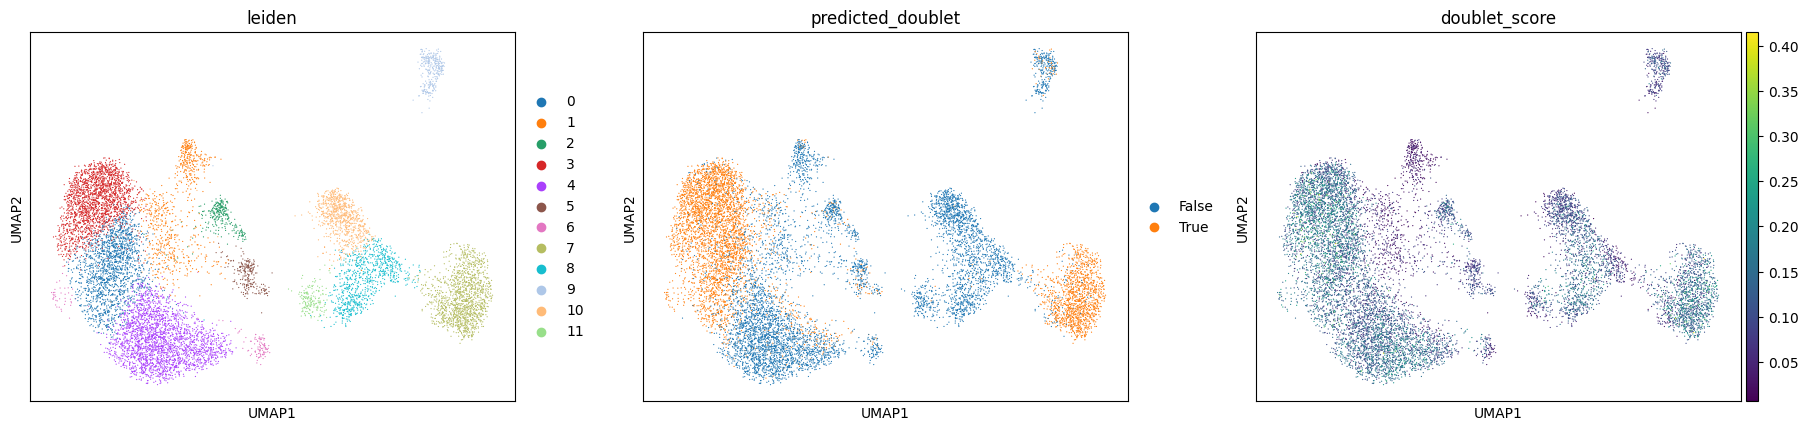

In [71]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.15,
    size=3,
)

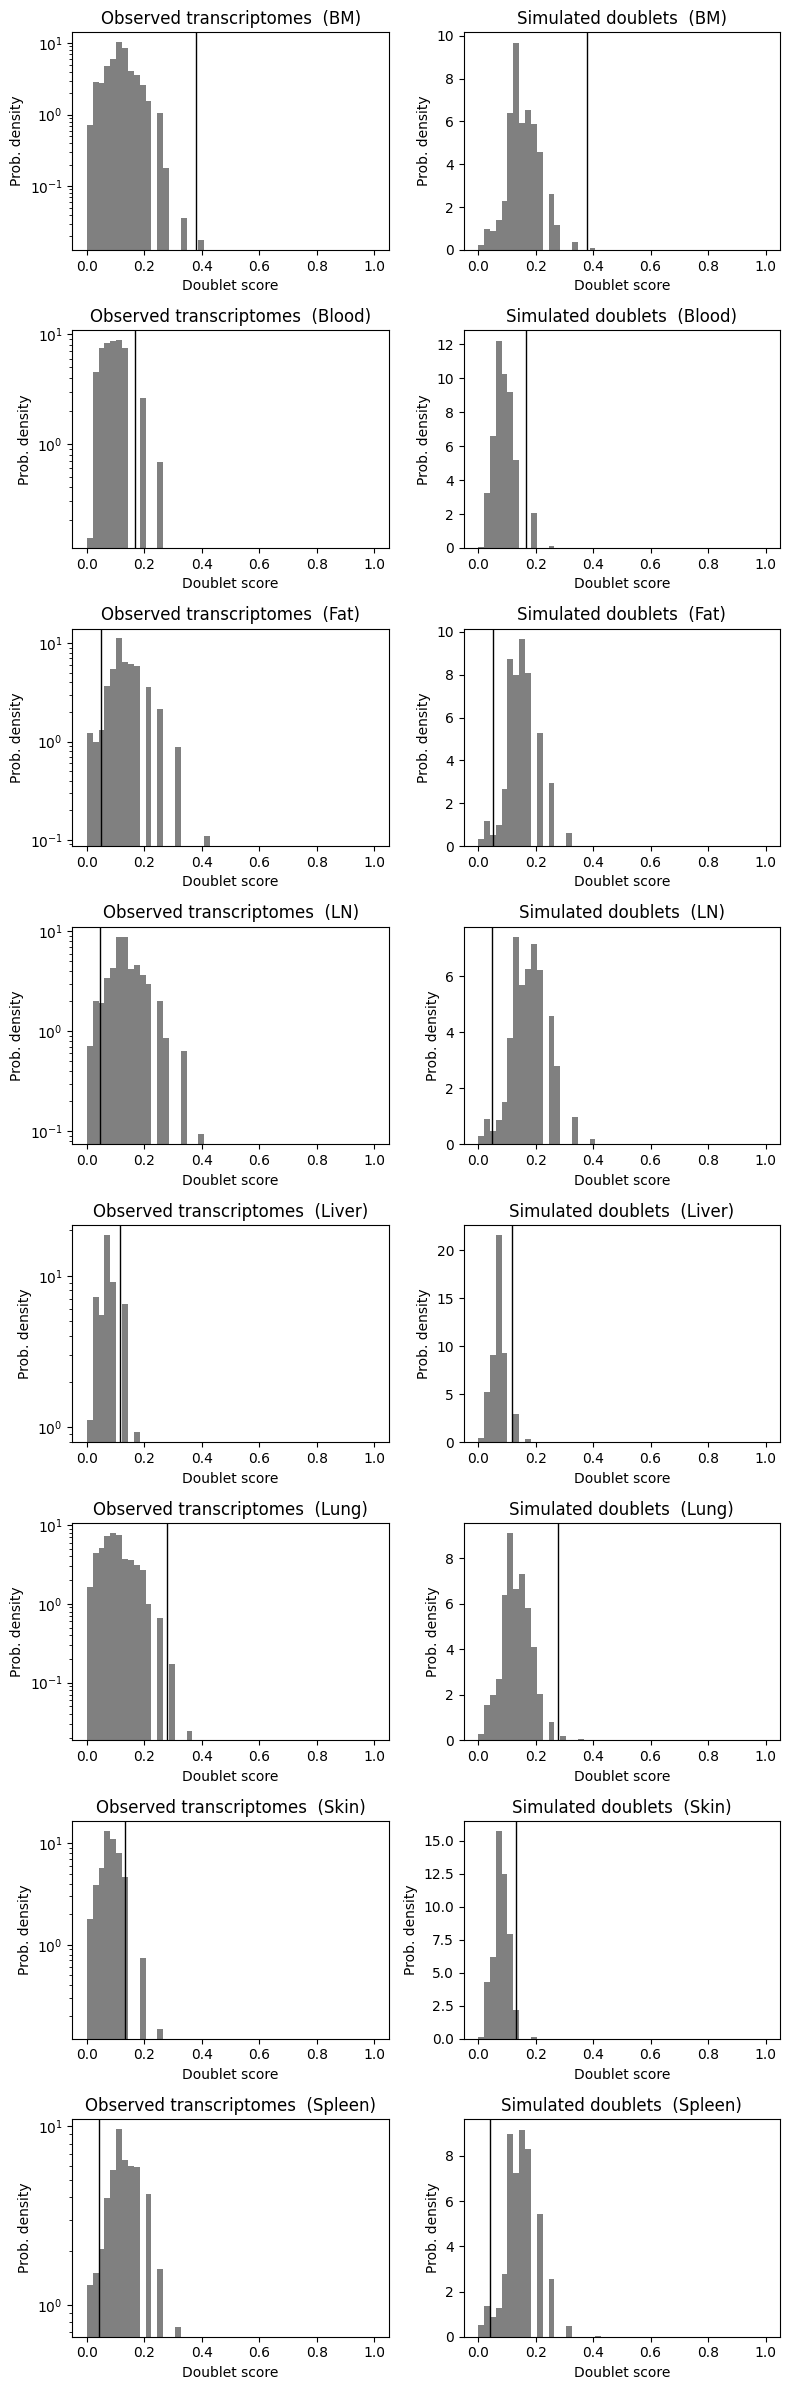

In [72]:
sc.pl.scrublet_score_distribution(adata)

In [73]:
# Doublet filter
#adata = adata[adata.obs.doublet_score <= 0.2]

In [74]:
# Mitochondria and surplus reads filter
# Filter cells with too many counts

# upper_lim = np.quantile(
#     adata.obs.n_genes_by_counts.values,
#     0.98)
# adata = adata[adata.obs.n_genes_by_counts < upper_lim]

# Filter cells with more than 20% mitochondrial reads
# adata = adata[adata.obs.pct_counts_mt < 20]

## Re-plot with filters

In [75]:
sc.pp.neighbors(adata)

In [76]:
sc.tl.umap(adata)

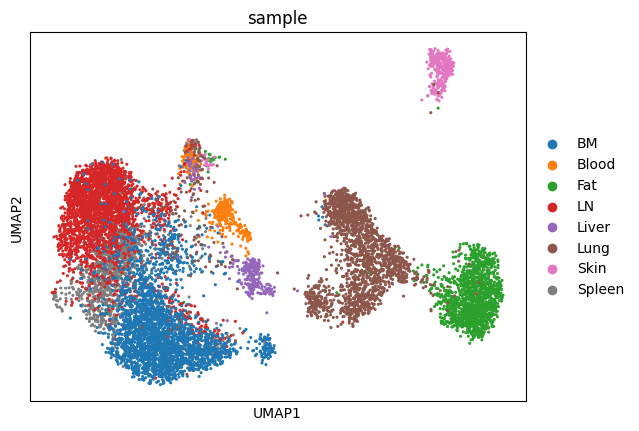

In [77]:
# UMAP with doublet filter

sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=20,
)

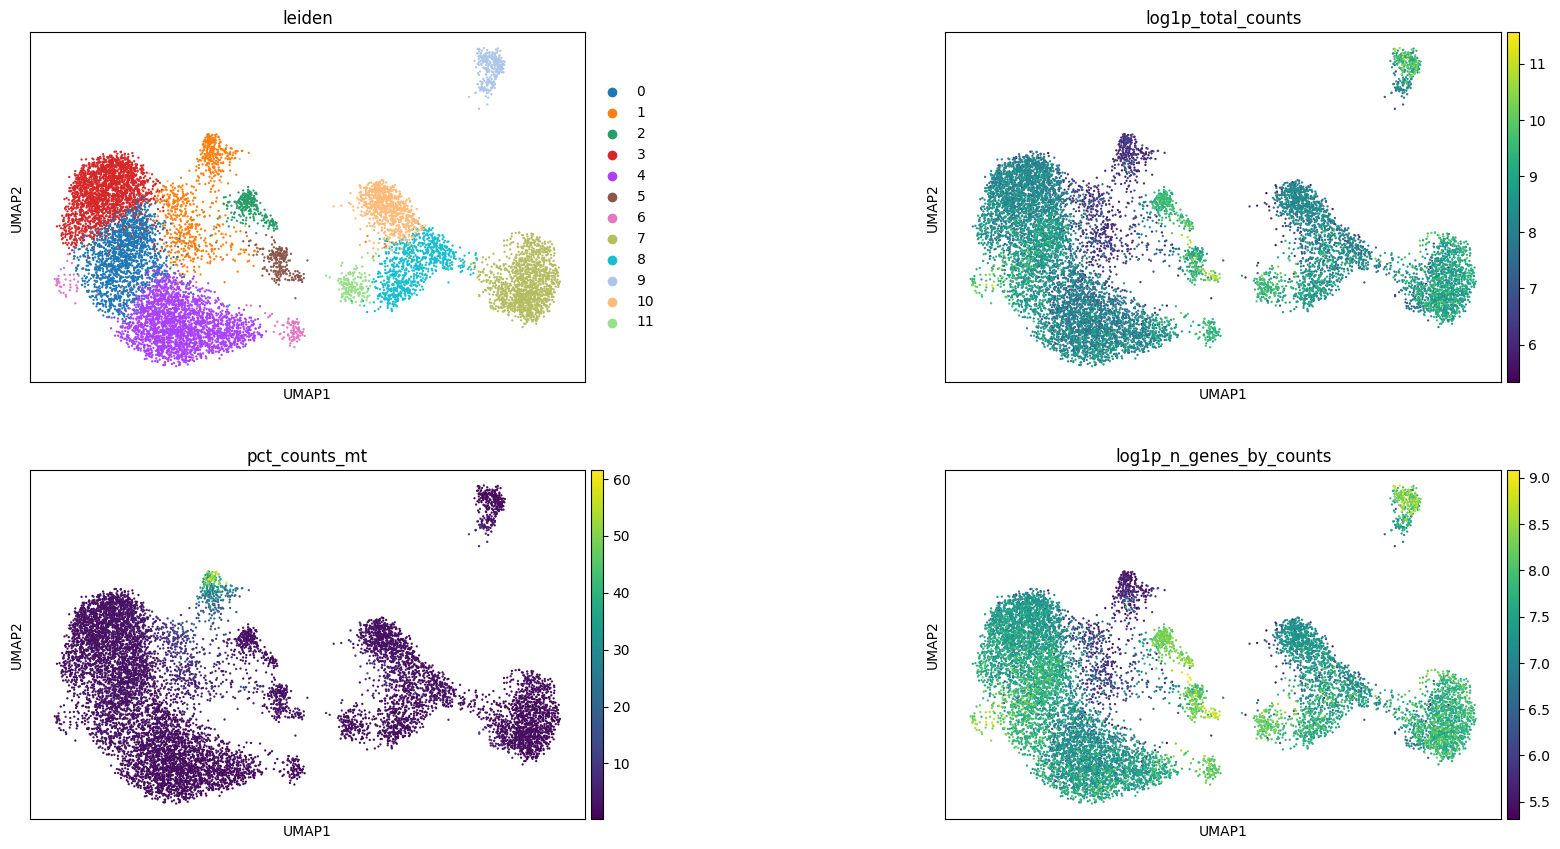

In [78]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

## Cell annotation

In [79]:
for res in [0.02, 0.52, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

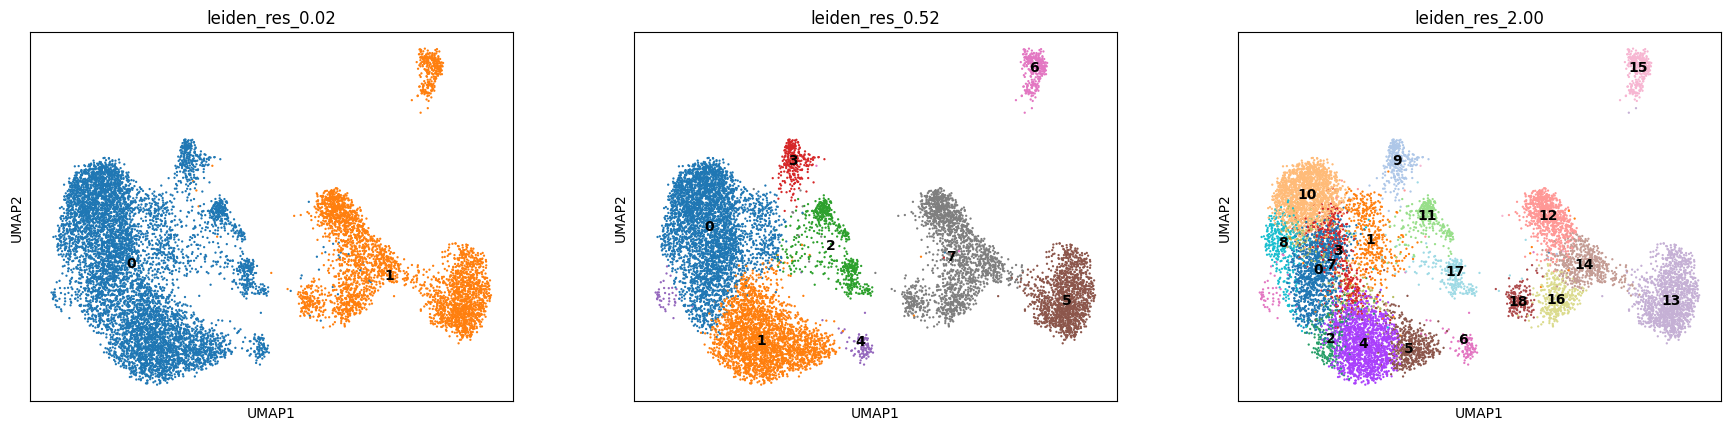

In [80]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.52", "leiden_res_2.00"],
    legend_loc="on data",
)

## Marker gene set from Differential Expression

In [81]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.52", method="wilcoxon")

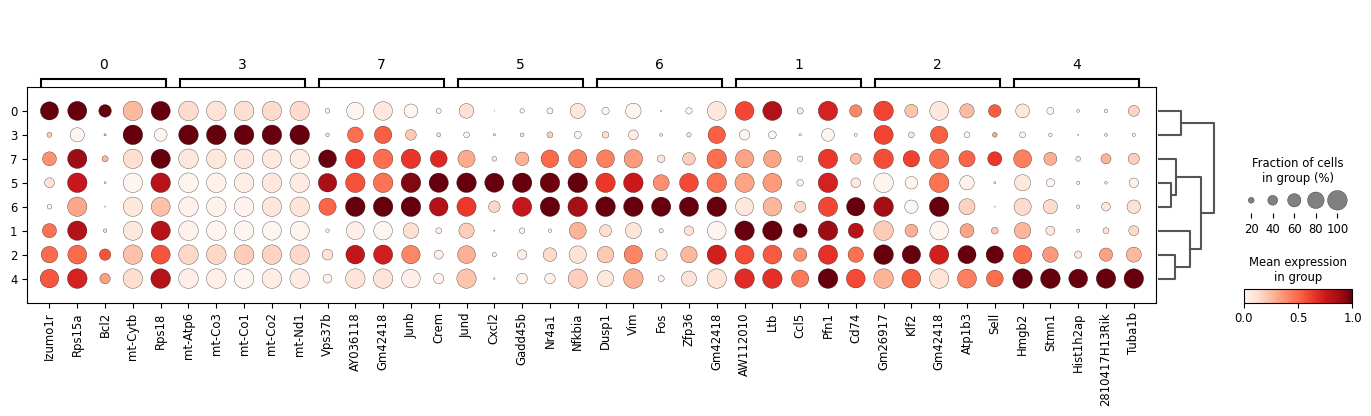

In [82]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.52", standard_scale="var", n_genes=5
)

In [83]:
# Top expressed genes in Fat Treg
sc.get.rank_genes_groups_df(adata, group="5").head(20)

names     scores  logfoldchanges  pvals  pvals_adj
0       Jund  56.943367        3.215254    0.0        0.0
1      Cxcl2  56.166374        6.252323    0.0        0.0
2    Gadd45b  56.007835        4.444253    0.0        0.0
3      Nr4a1  55.378288        4.105432    0.0        0.0
4     Nfkbia  55.227966        2.792222    0.0        0.0
5       Areg  53.679146        4.417136    0.0        0.0
6       Lmna  53.569363        4.166308    0.0        0.0
7     S100a6  53.098698        3.207824    0.0        0.0
8       Junb  53.012123        3.020746    0.0        0.0
9     Il1rl1  53.006092        3.467560    0.0        0.0
10  AA467197  52.940334        6.681938    0.0        0.0
11      Odc1  52.422882        3.049384    0.0        0.0
12      Il10  52.349953        5.240431    0.0        0.0
13    Ctla2a  52.285606        3.450659    0.0        0.0
14      Rgs2  52.051212        3.804332    0.0        0.0
15    Hilpda  50.735241        4.000844    0.0        0.0
16    S100a4  50.634811        3.171948    0.0        0.0
17    Nfkbiz  50.620934        2.968423    0.0        0.0
18    Nfkbid  50.567650        3.460543    0.0        0.0
19     Klrg1  50.470329        2.680537    0.0        0.0

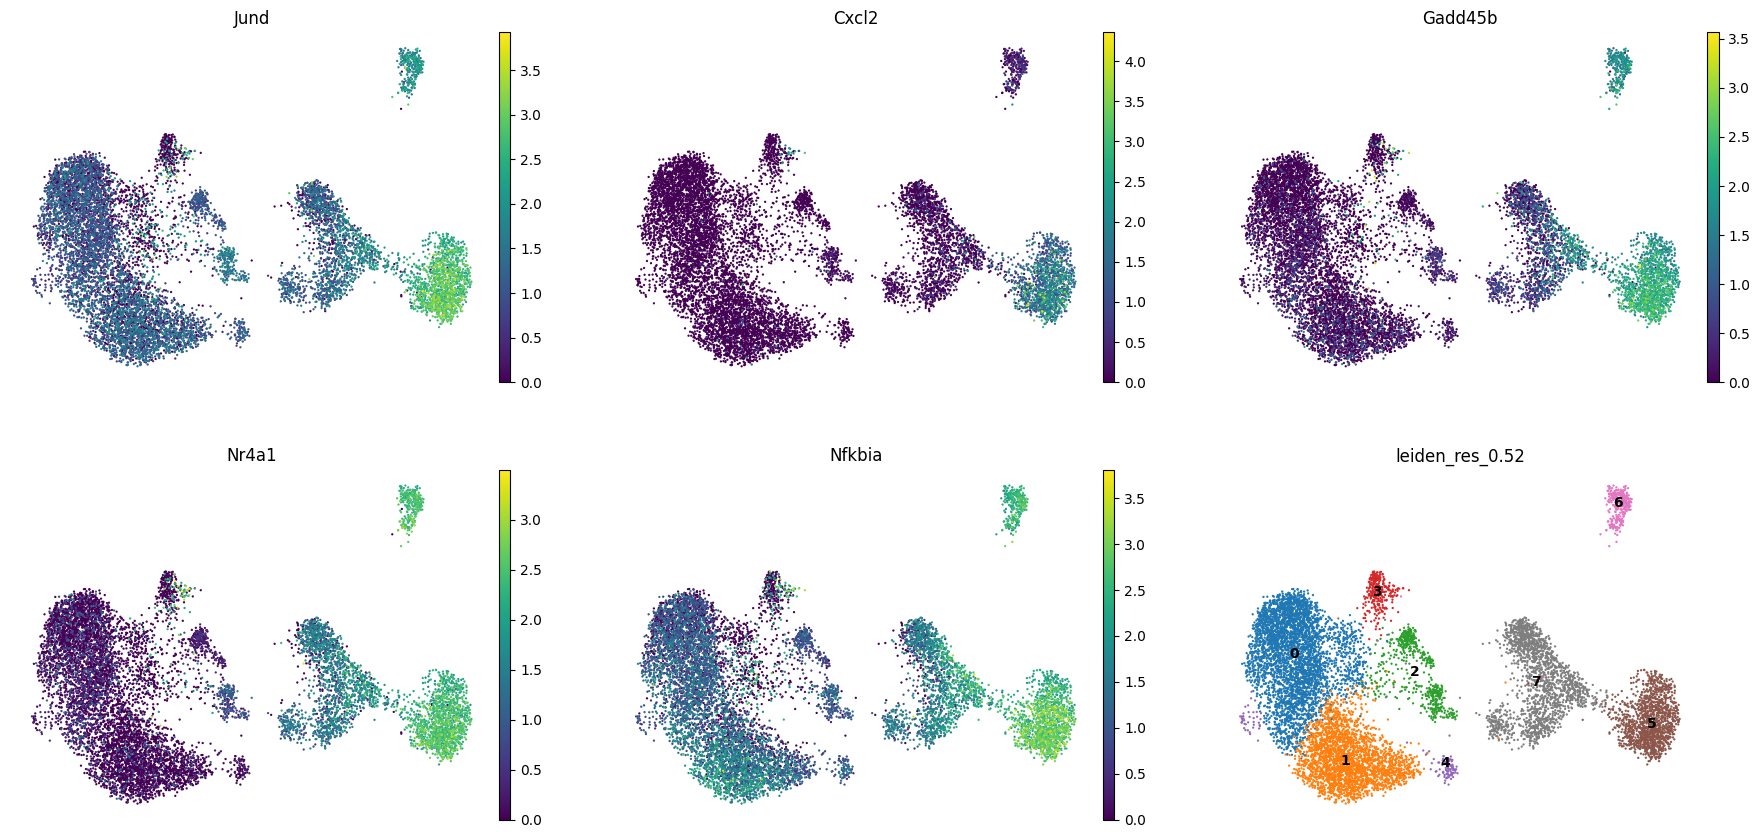

In [84]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="5").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.52"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

## Checking expression of the genes of interest

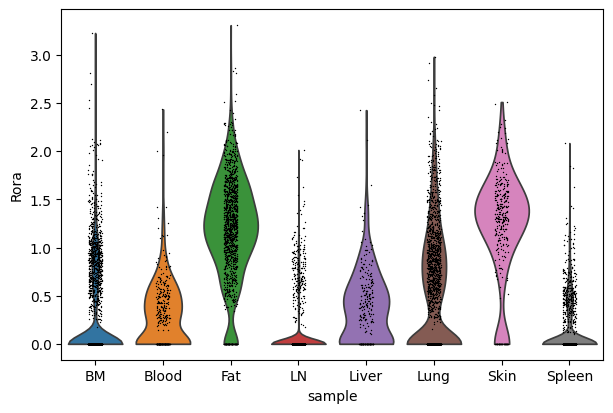

In [85]:
sc.pl.violin(adata, ["Rora"], groupby="sample")

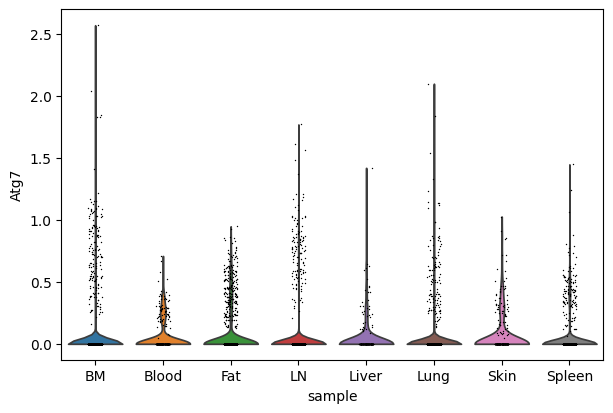

In [86]:
sc.pl.violin(adata, ["Atg7"], groupby="sample")

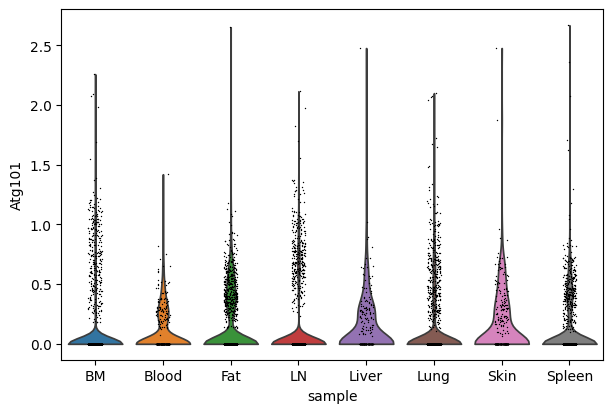

In [87]:
sc.pl.violin(adata, ["Atg101"], groupby="sample")

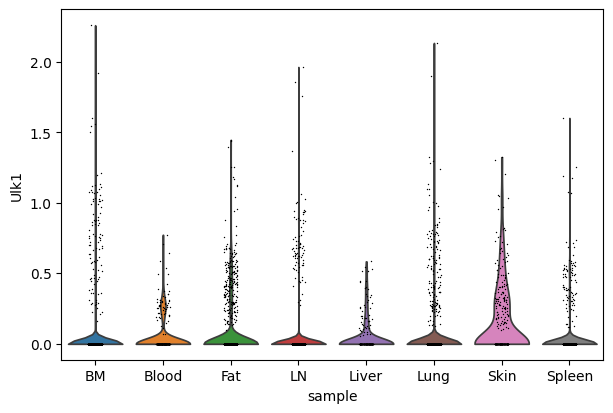

In [88]:
sc.pl.violin(adata, ["Ulk1"], groupby="sample")

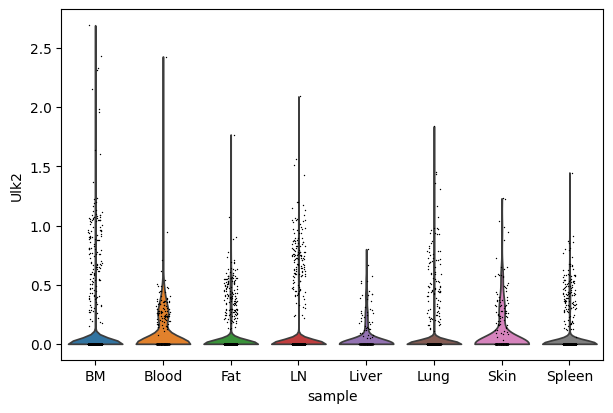

In [89]:
sc.pl.violin(adata, ["Ulk2"], groupby="sample")

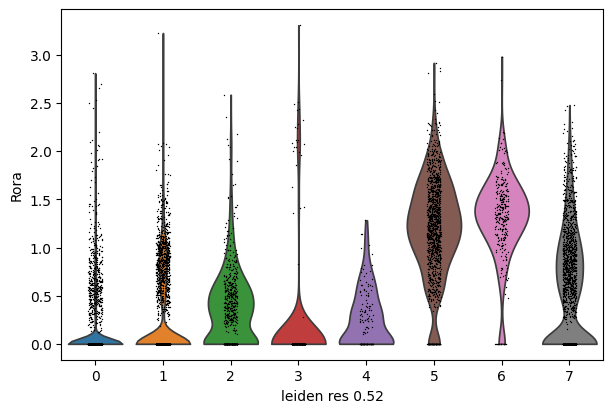

In [90]:
sc.pl.violin(adata, ["Rora"], groupby="leiden_res_0.52")

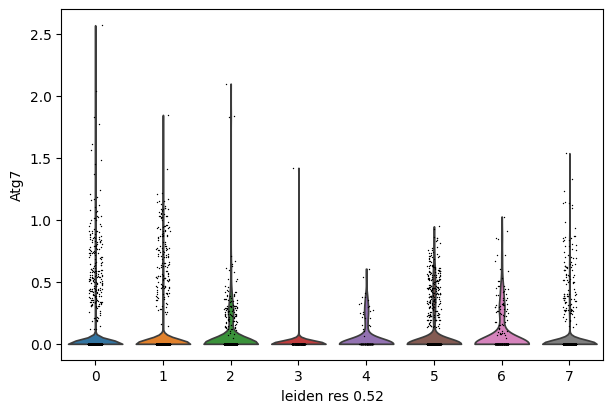

In [91]:
sc.pl.violin(adata, ["Atg7"], groupby="leiden_res_0.52")

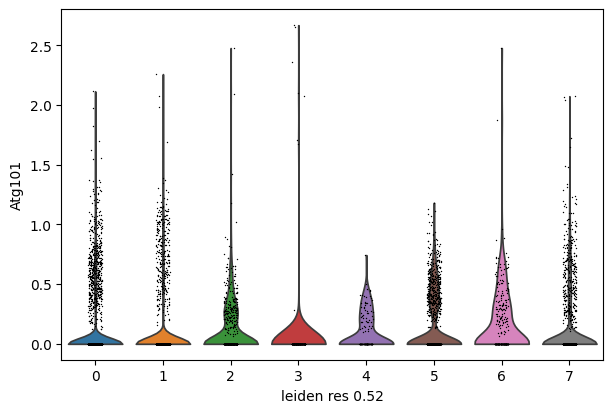

In [92]:
sc.pl.violin(adata, ["Atg101"], groupby="leiden_res_0.52")

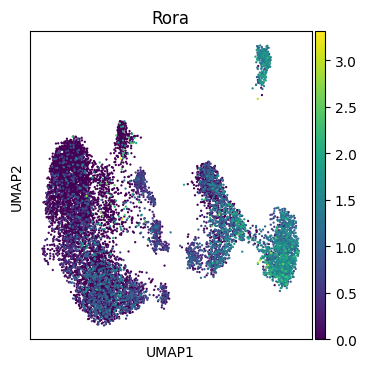

In [93]:
# rc_context is used for the figure size, in this case 4x4
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(
        adata,
        color="Rora",
        legend_loc="on data"
    )

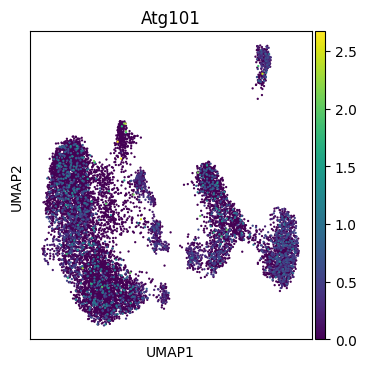

In [94]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color="Atg101")

In [95]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

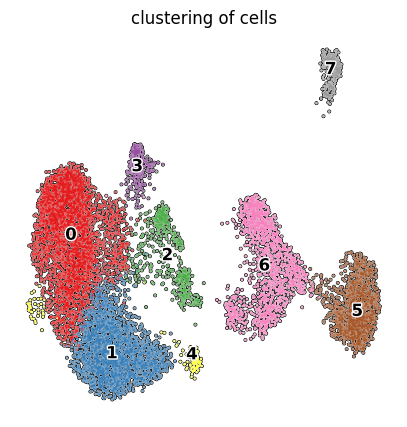

In [96]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

## Trajectories

In [ ]:
# WARNING: Alternative preprocessing here
DO_ALT_PREPROC = False

In [9]:
if DO_ALT_PREPROC:
    settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
    sc.logging.print_versions()
    results_file = "./write/paul15.h5ad"
    # low dpi (dots per inch) yields small inline figures
    sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

-----
anndata     0.11.3
scanpy      1.10.4
-----
PIL                 11.1.0
asttokens           NA
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.12
decorator           5.1.1
executing           2.2.0
h5py                3.12.1
igraph              0.11.8
ipykernel           6.29.5
jedi                0.19.2
joblib              1.4.2
kiwisolver          1.4.8
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.44.0
matplotlib          3.10.0
mpl_toolkits        NA
natsort             8.4.0
numba               0.61.0
numpy               2.1.3
packaging           24.2
pandas              2.2.3
parso               0.8.4
platformdirs        4.3.6
prompt_toolkit      3.0.50
psutil              6.1.1
pure_eval           0.2.3
pydev_ipython       NA
pydevconsole        NA
pydevd              3.2.3
pydevd_file_utils   NA
pydevd_plugins      NA
pydevd_tracing      NA
pygments            2.19

In [10]:
if DO_ALT_PREPROC:
    sc.pp.recipe_zheng17(adata)

running recipe zheng17
filtered out 12 genes that are detected in less than 1 counts
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:01)


In [11]:
if DO_ALT_PREPROC:
    sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


In [12]:
if DO_ALT_PREPROC:
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20


/home/nikiarte/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:02:25)


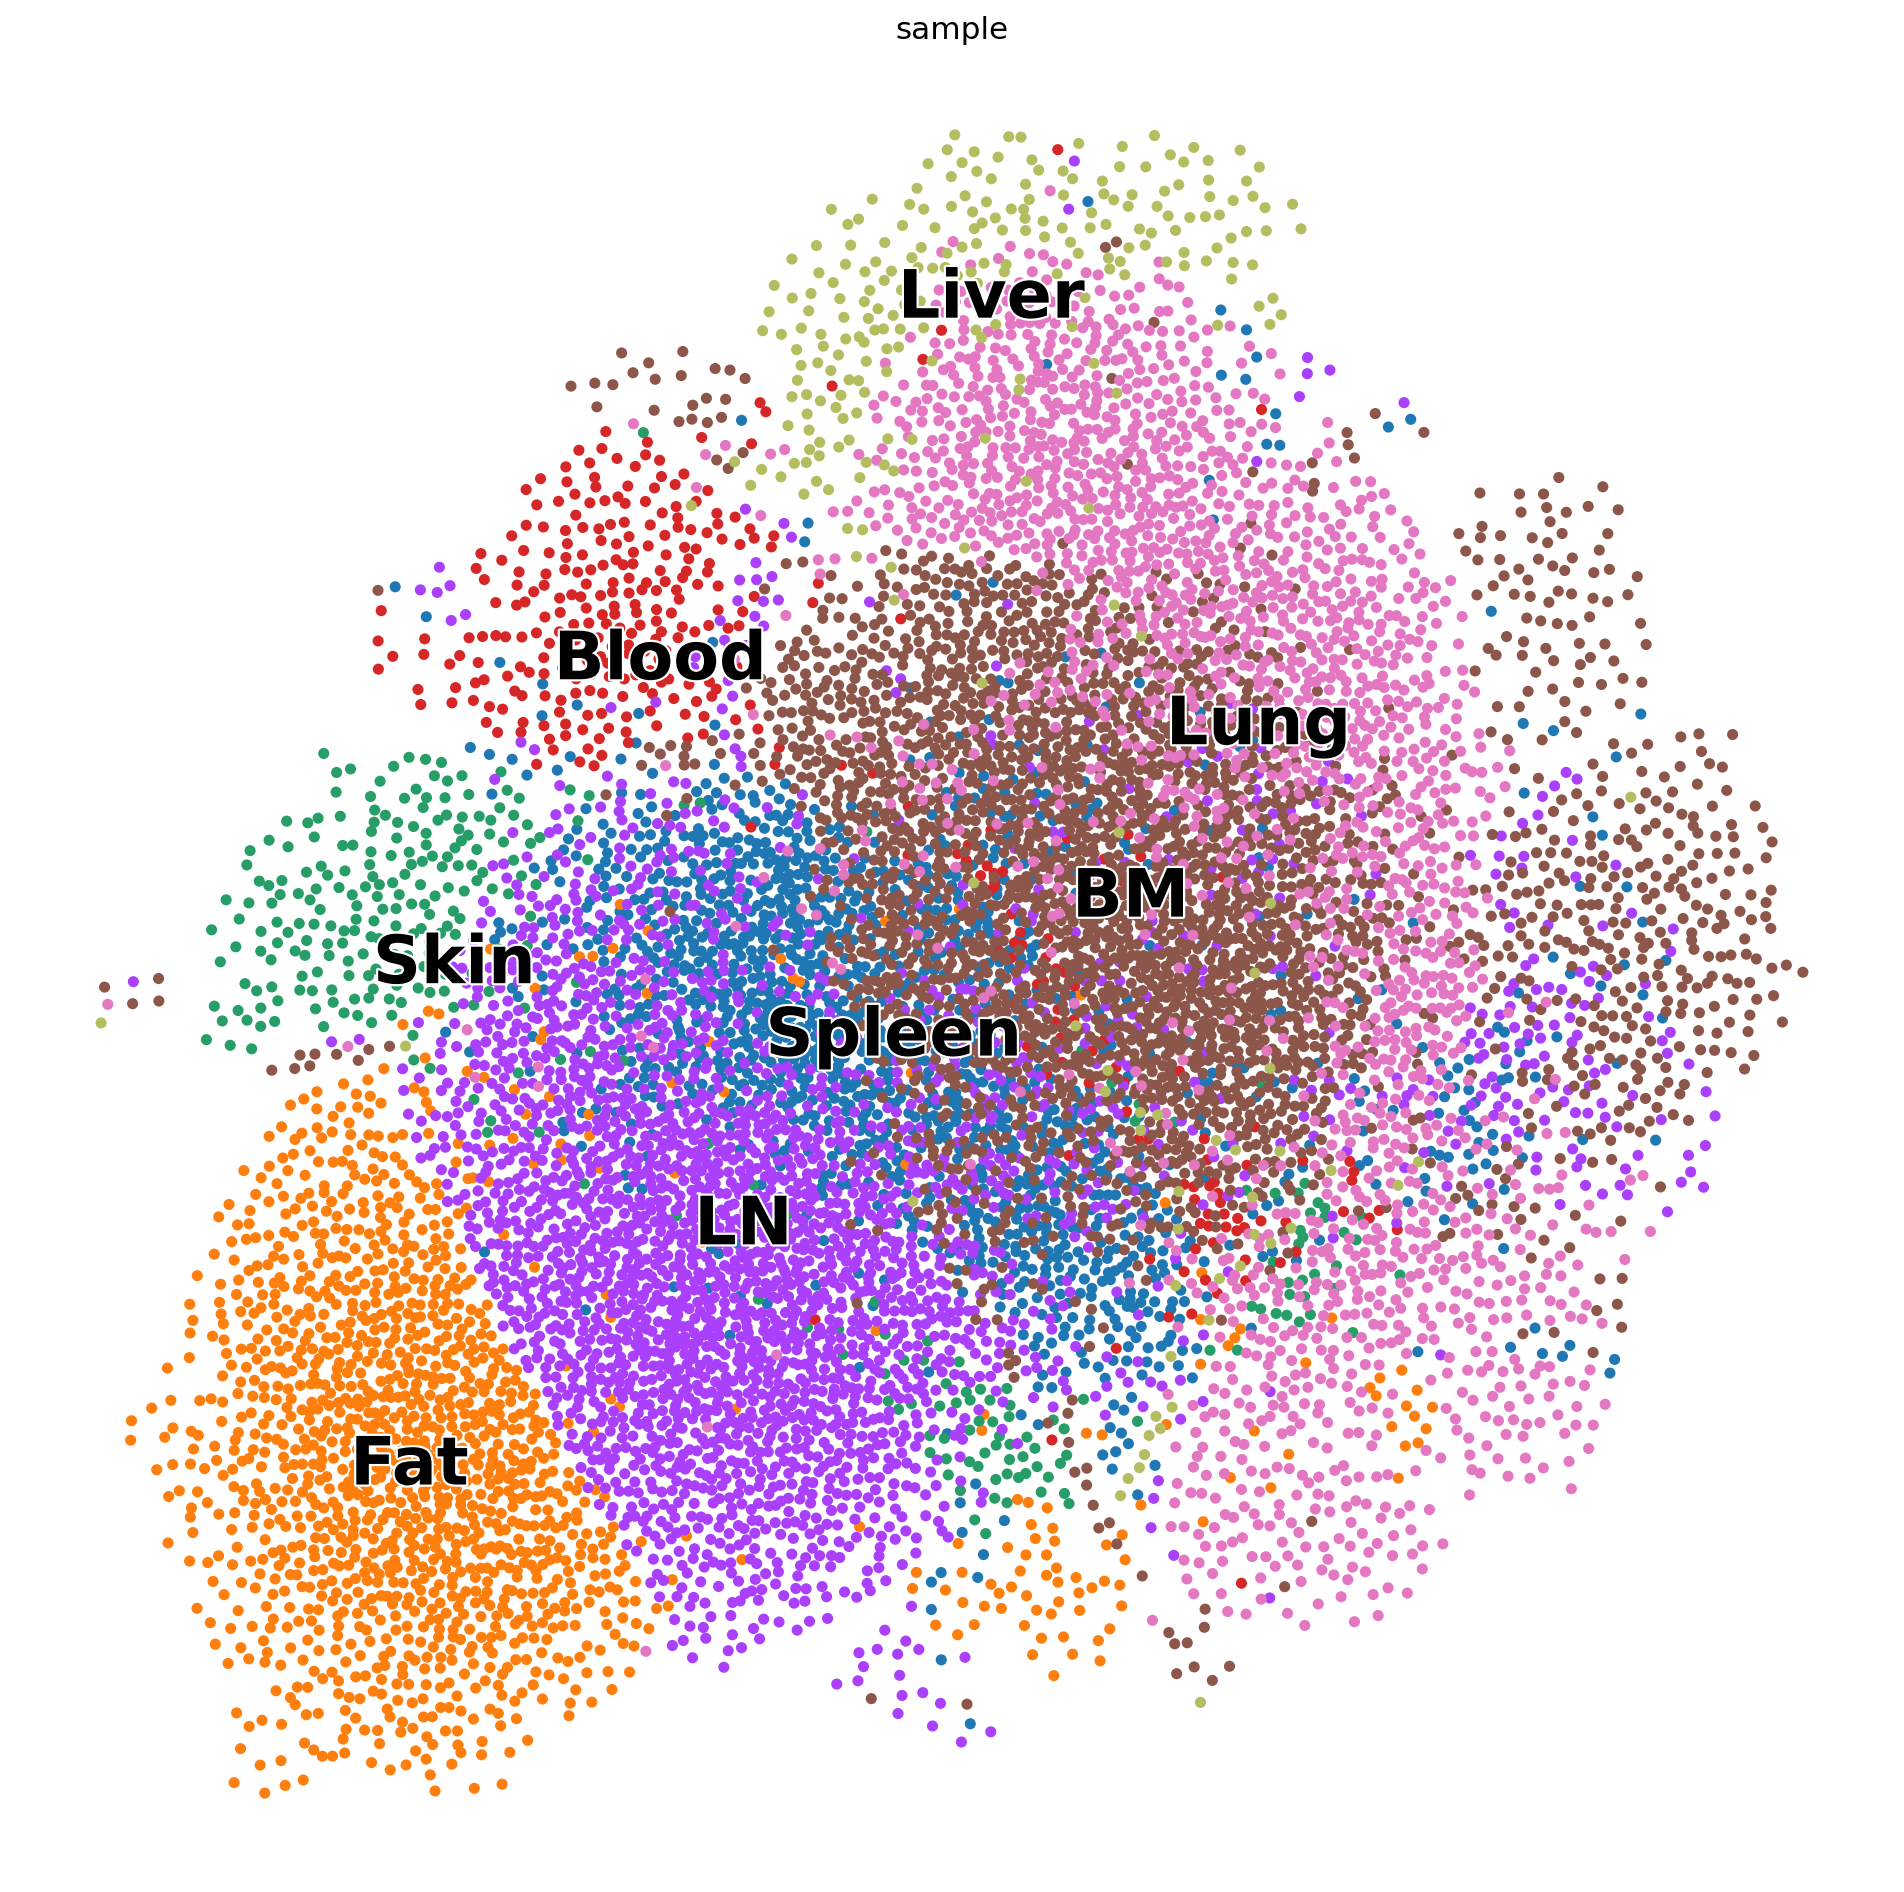

In [23]:
with rc_context({"figure.figsize": (15, 15)}):
    sc.pl.draw_graph(
        adata,
        color="sample",
        size=100,
        legend_loc="on data",
        legend_fontsize=30,
        legend_fontoutline=2,
    )

In [24]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9995202  0.9989339  0.9983833  0.997611
     0.99722314 0.9958926  0.9957468  0.99541837 0.9951978  0.9937001
     0.99349755 0.99314934 0.9927322 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [25]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:20)


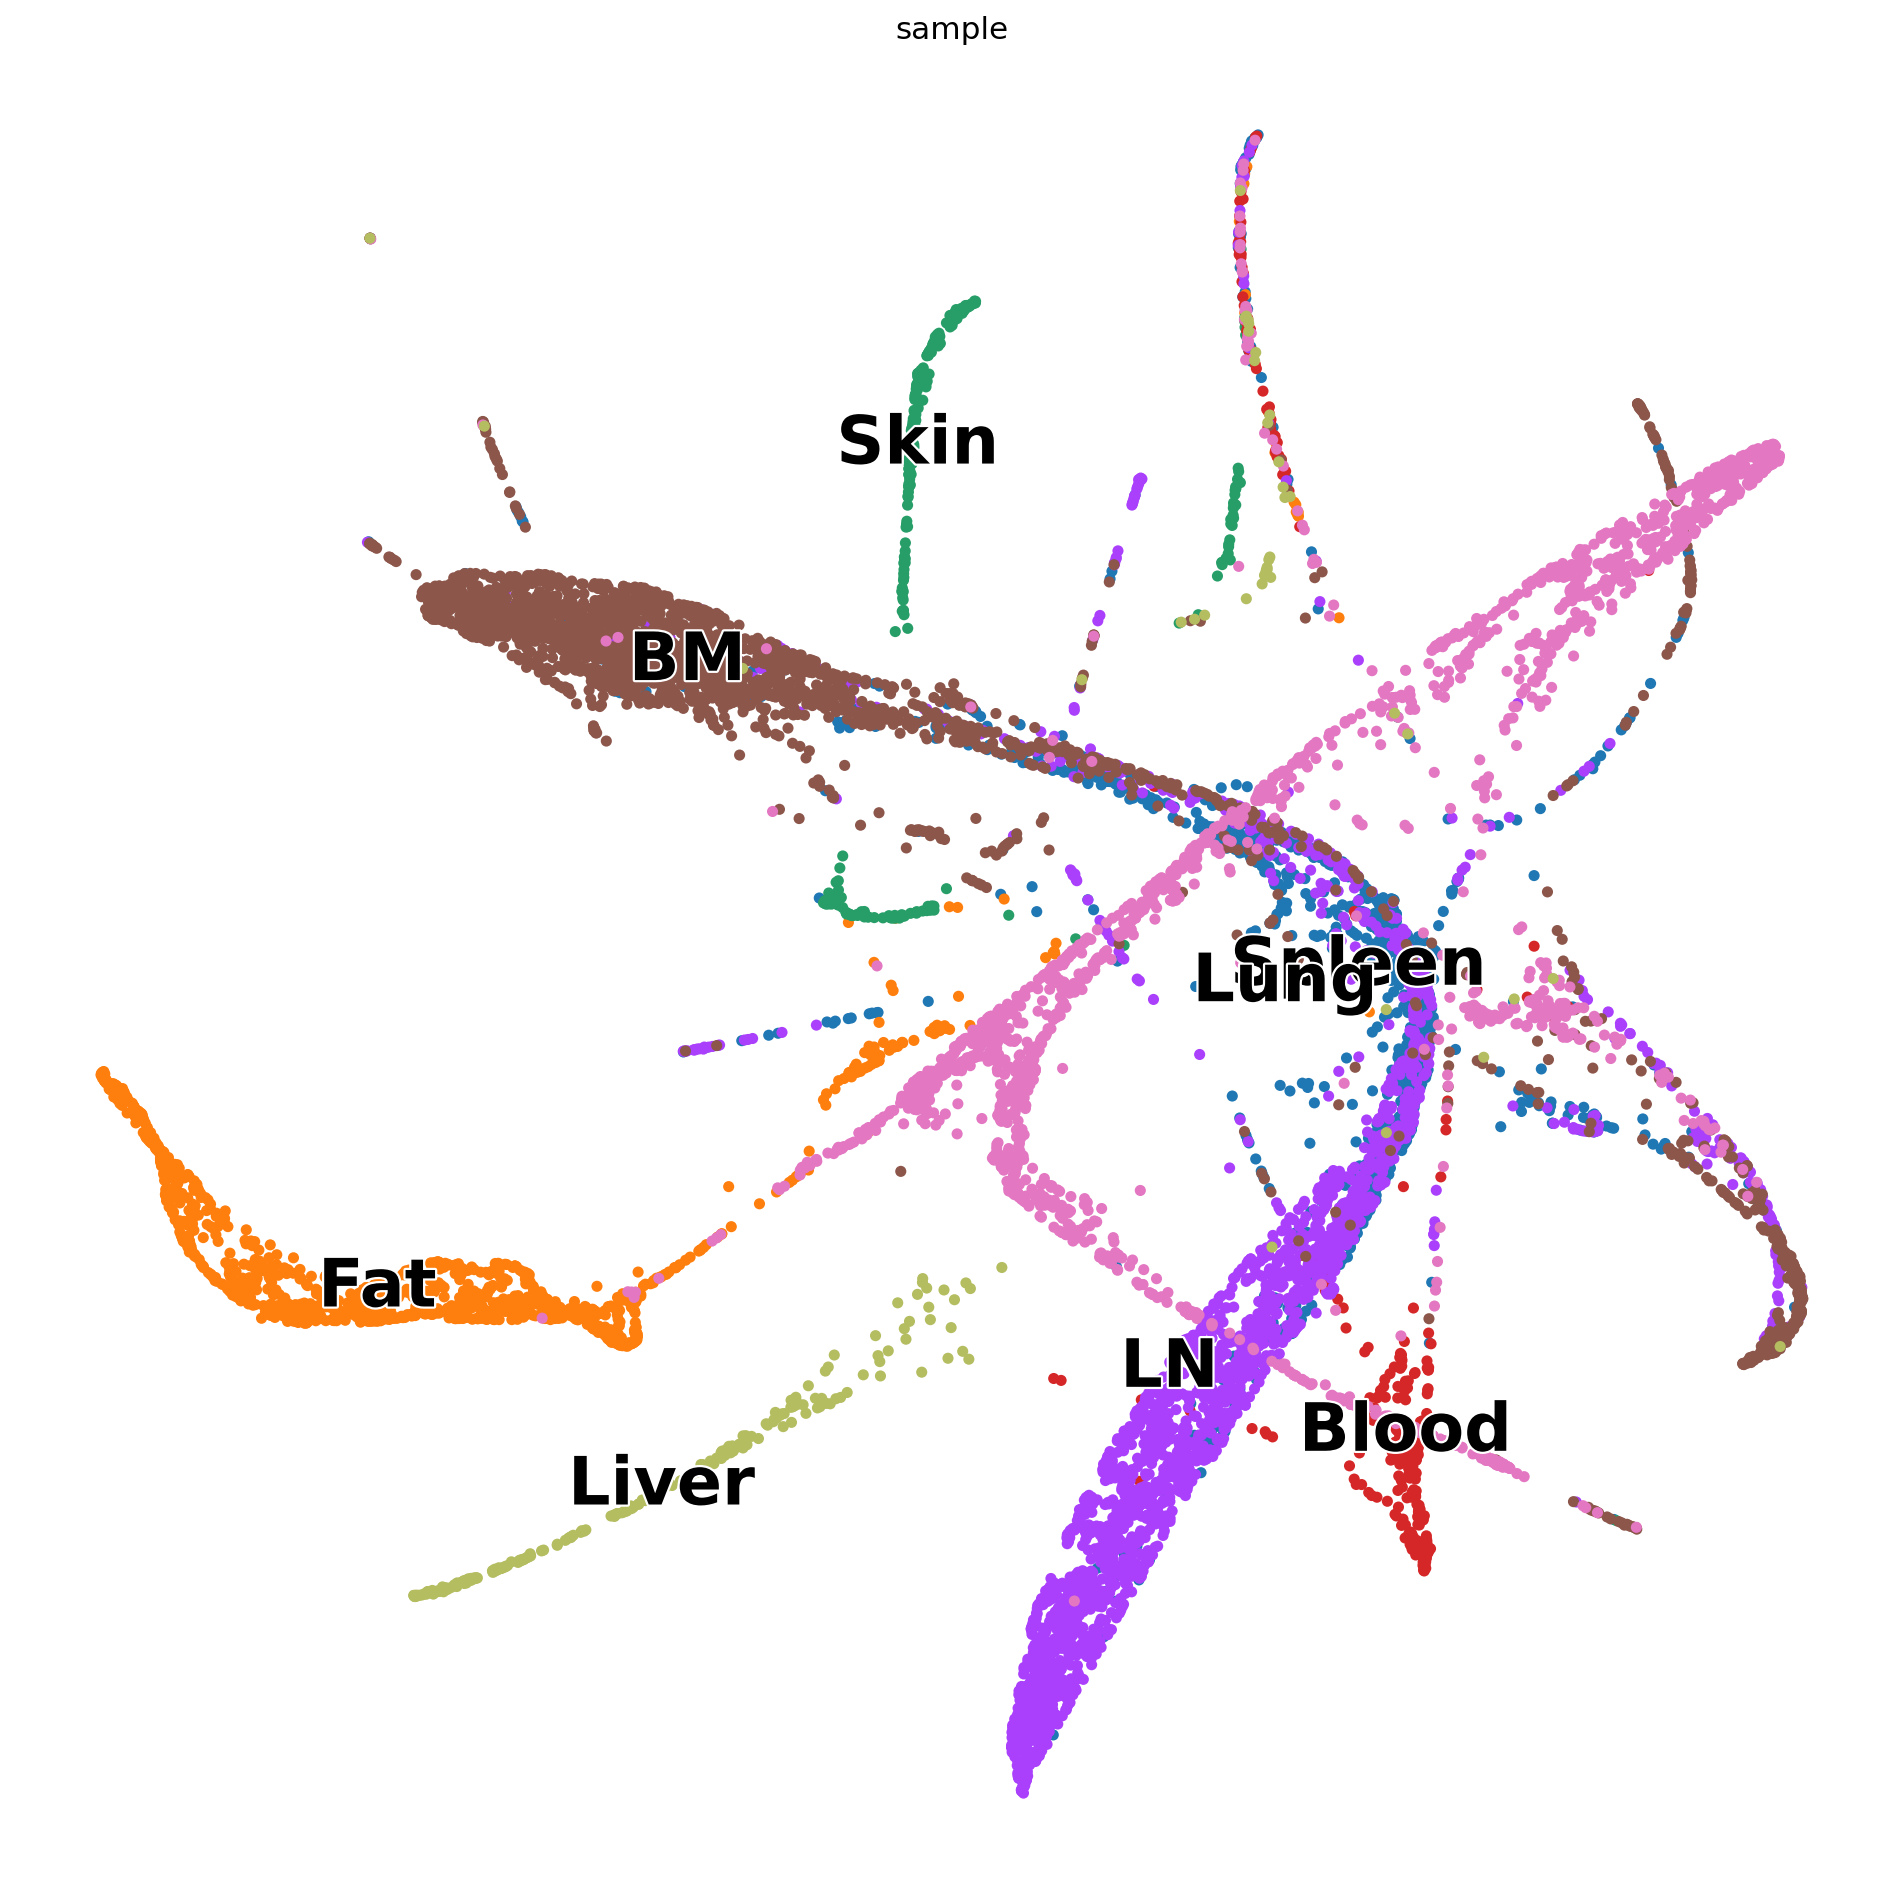

In [29]:
with rc_context({"figure.figsize": (15, 15)}):
    sc.pl.draw_graph(
        adata,
        color="sample",
        size=100,
        legend_loc="on data",
        legend_fontsize=30,
        legend_fontoutline=2,)

In [33]:
sc.tl.leiden(adata, resolution=0.52)

running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [34]:
sc.tl.paga(adata, groups="leiden")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


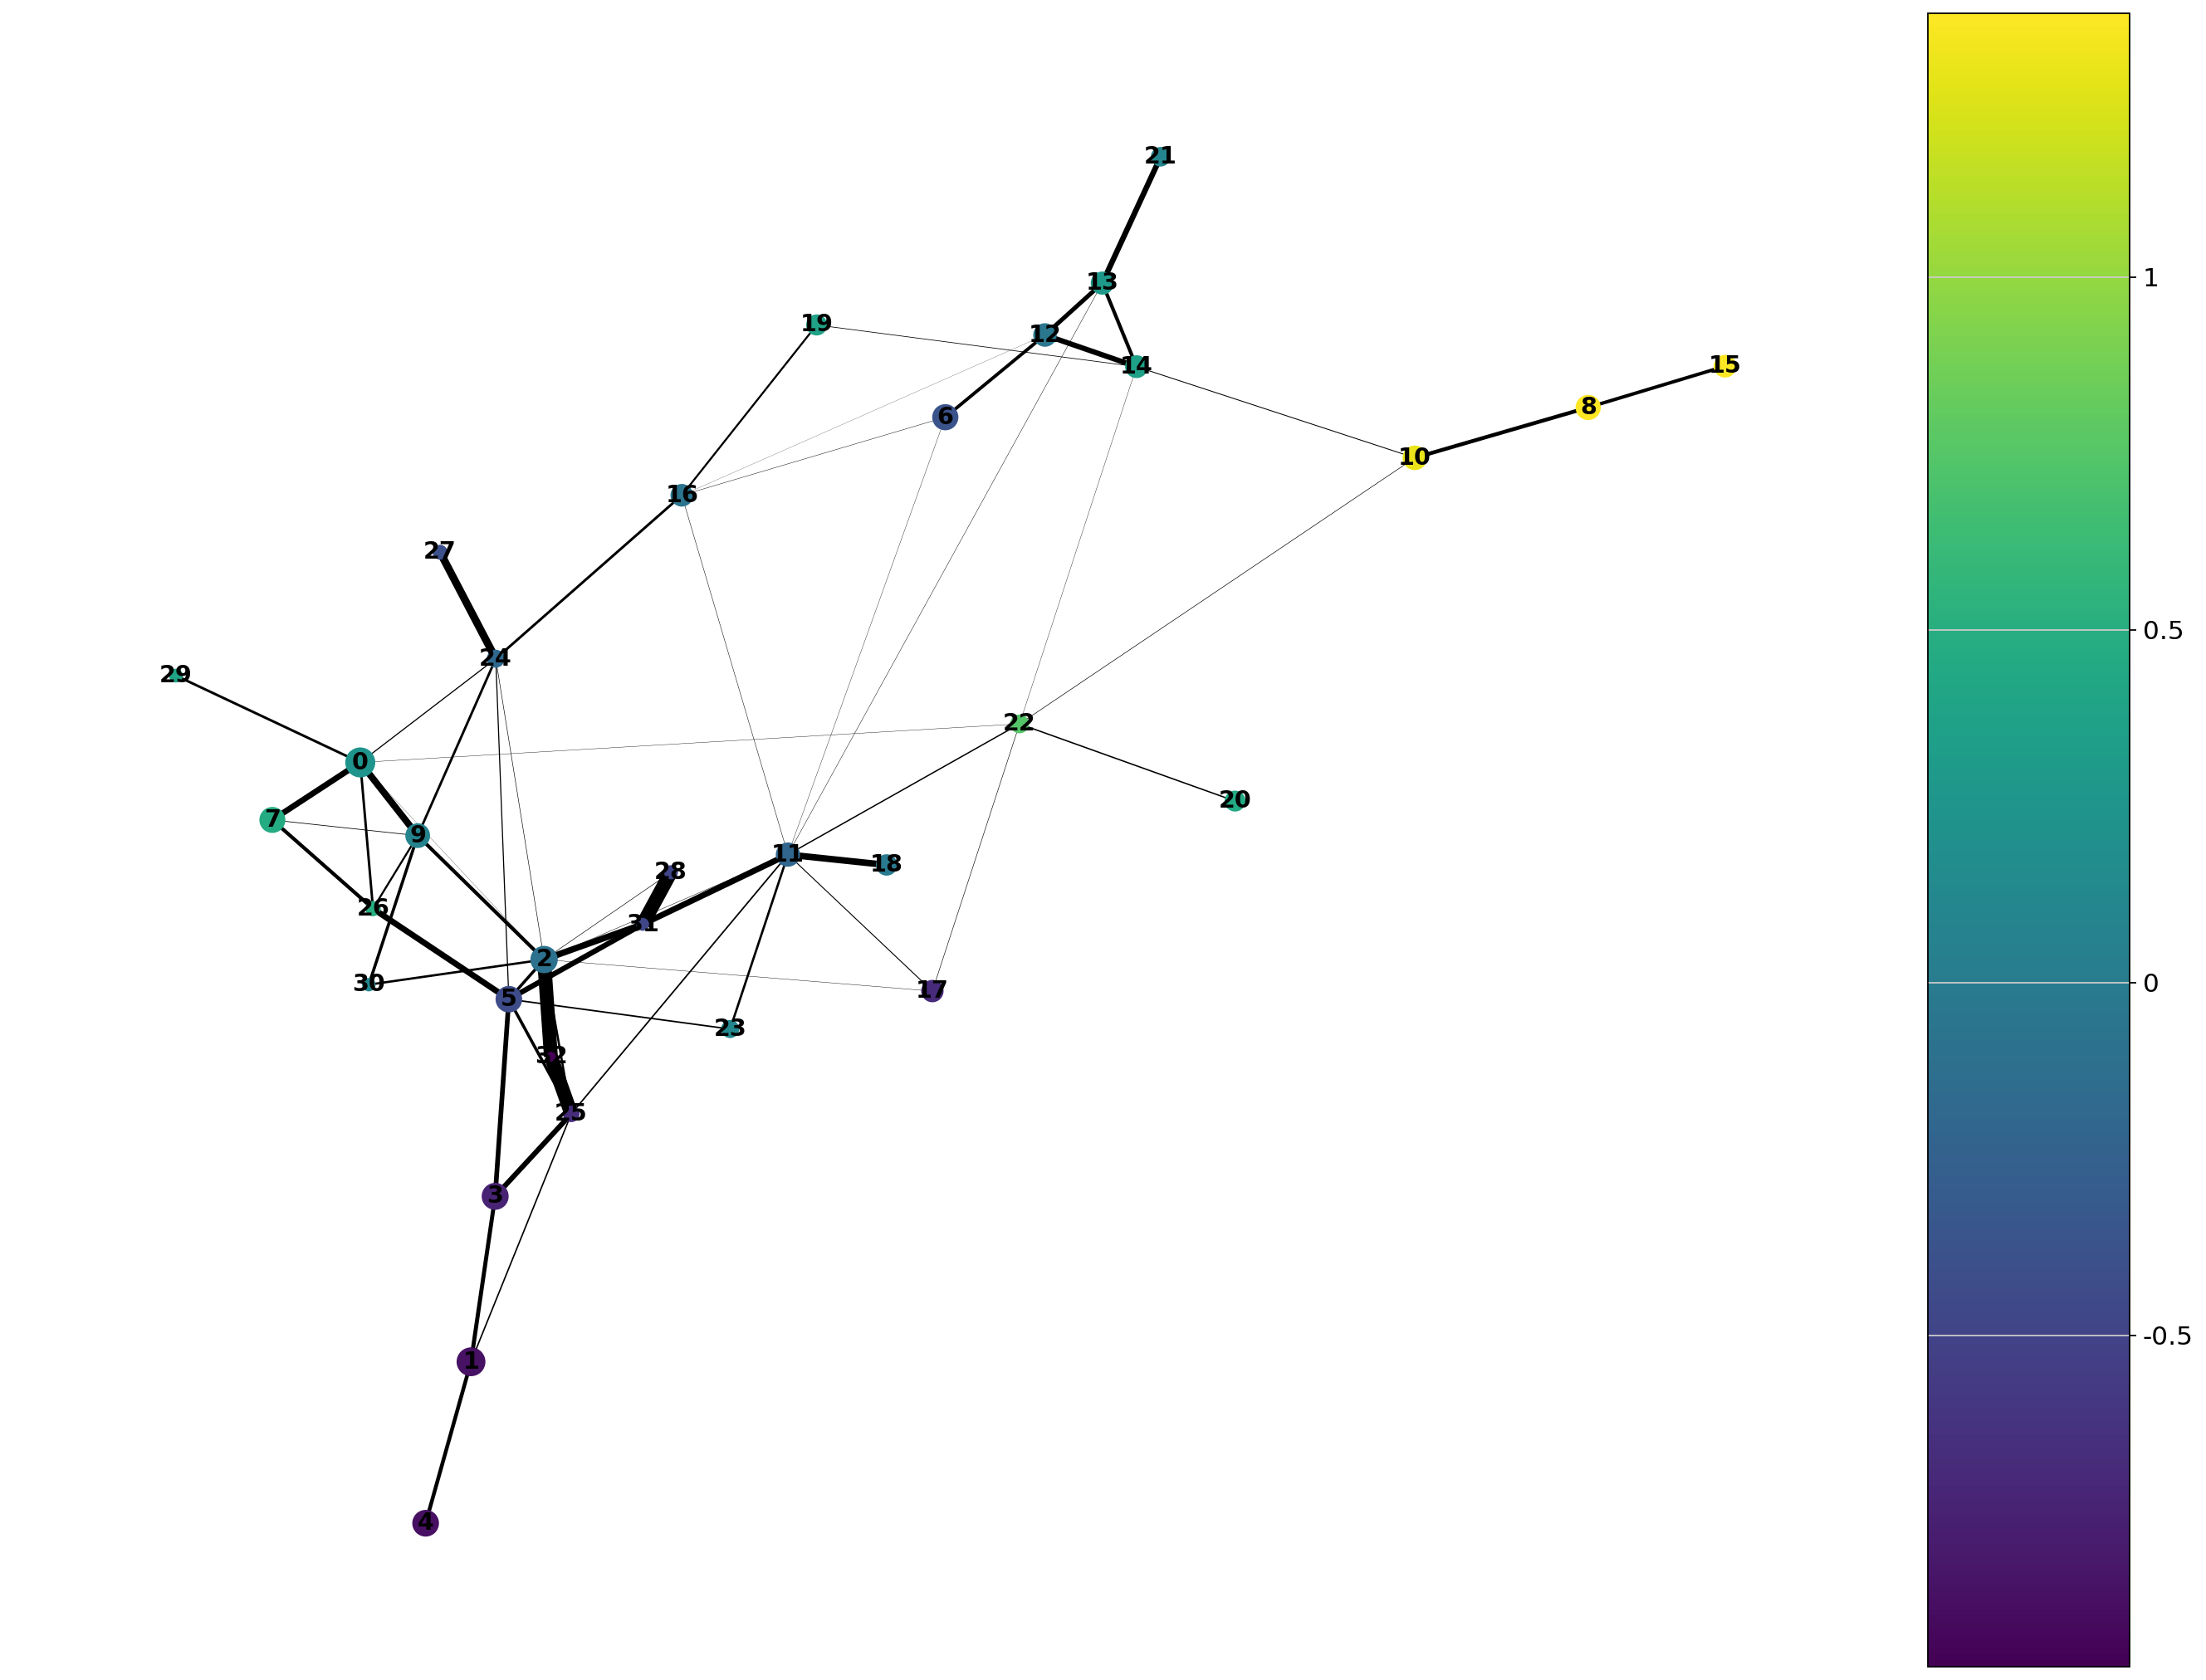

In [46]:
with rc_context({"figure.figsize": (15, 15)}):
    sc.pl.paga(
        adata,
        color=["Klrg1"]
    )

In [41]:
adata.obs["leiden"].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype='object')

In [42]:
adata.obs["leiden_anno"] = adata.obs["leiden"]